# CEE 697M - Final Project: Jerry Chen and Aniruddha Prasad


## Import Required Libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from patsy import dmatrix

from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.utils import resample

import statsmodels.api as sm
from statsmodels.gam.tests.test_penalized import df_autos
from statsmodels.gam.smooth_basis import BSplines
from statsmodels.gam.generalized_additive_model import GLMGam

import scipy as sp
from scipy.interpolate import interp1d







## Import the data:

In [2]:
# df = pd.read_spss("1ResearchProjectData.sav")
df = pd.read_csv("1ResearchProjectData.csv")

## Encode data into classes by hand to make applying models easier.
df = df.drop(columns=['wesson'])
df = df.dropna()

## Pre-process the data

### Replace the name of teacher with 1, 2 or 3
 Ruger = 1
 Wesson = 2
 Smith = 3
### Replace lunch status with 0 and 1
 Free lunch = 0
 Paid lunch = 1
### Replace Gender with 1's and 0's
 Female = 0
 Male = 1
### Replace ethinicity with 1 through 4
 African American = 1
 Hispanic = 2
 Caucasian = 3
 Asian = 4

In [4]:
# Teacher
df.replace('Ruger',1,inplace=True)
df.replace('Wesson',2,inplace=True)
df.replace('Smith',3,inplace=True)

# Lunch status
df.replace('Free lunch',0,inplace=True)
df.replace('Paid lunch',1,inplace=True)

# Gender:
df.replace('Female',0,inplace=True)
df.replace('Male',1,inplace=True)

#Ethnicity
df.replace('African-American',1,inplace=True)
df.replace('Hispanic',2,inplace=True)
df.replace('Caucasian',3,inplace=True)
df.replace('Asian',4,inplace=True)

corrM = df.corr()
corrM.style.background_gradient(cmap='coolwarm').set_precision(2)

/var/folders/td/4gbkcr014tv3dc_zms9z1h4m0000gn/T/ipykernel_44135/2022140511.py:21: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corrM.style.background_gradient(cmap='coolwarm').set_precision(2)


,Student,Teacher,Gender,Ethnic,Freeredu,Score
Student,1.00,0.46,-0.03,0.03,0.00,0.37
Teacher,0.46,1.00,0.04,0.07,0.08,0.36
Gender,-0.03,0.04,1.00,-0.06,0.01,-0.13
Ethnic,0.03,0.07,-0.06,1.00,0.03,-0.01
Freeredu,0.00,0.08,0.01,0.03,1.00,-0.04
Score,0.37,0.36,-0.13,-0.01,-0.04,1.00


## Split data into Training and Validation sets:

Regression models: KNN, Multivariate Regression, OLS

Classification models: KNN, SVC, random forest classifier

### KNN Regression

In [30]:
X = pd.DataFrame(df, columns=['Teacher', 'Gender', 'Ethnic', 'Freeredu'])
y = pd.DataFrame(df, columns=['Score'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

clf = KNeighborsRegressor(n_neighbors=5, p=2)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(f'accuracy: {clf.score(X_train, y_train)}')


accuracy: 0.26998355530092244


#### Perform gridsearch to find best hyperparameters

In [31]:
n = np.arange(1, 20, 1)
p = np.arange(1,3,1)

params = { 'n_neighbors' : n, 'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'), 'p': p  }# The param we want to figure out using the grid search
kNN = KNeighborsRegressor()
kNN_gscv = GridSearchCV(kNN, params, cv=5)# Grid search with five fold cross validation
#fit model to data
kNN_gscv.fit(X_train, y_train)
print(kNN_gscv.best_params_)

{'algorithm': 'ball_tree', 'n_neighbors': 19, 'p': 2}


#### Retrain model with the these new best hyperparams

In [24]:
knn = KNeighborsRegressor(n_neighbors=19,algorithm='brute',p=2)

knn.fit(X_train,y_train)
yPred = knn.predict(X_test)
yPred = np.around(yPred)
MSE = mean_squared_error(y_true=y_test,y_pred=yPred)
RMSE = np.sqrt(MSE)
score = knn.score(X_test,y_test)

print("The RMSE for this model is {} and the accuracy is {}".format(RMSE,score))

The RMSE for this model is 15.772419940175027 and the accuracy is 0.04190398665323691


#### Use Cross validation score to improve accuracy

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklear

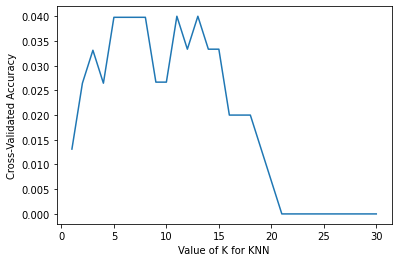

In [41]:
k_range = range(1, 31)

# list of scores from k_range
k_scores = []

# 1. we will loop through reasonable values of k
for k in k_range:
    # 2. run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute',p=2)
    # 3. obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn, X_train, y_train[:], cv=5, scoring='accuracy')
    # 4. append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())

plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()


Essentially KNN is a bad model to use here. It has given consistently low accuracy so we will instead try some other models

## Polynomial Regression with degree 1

In [59]:
X = pd.DataFrame(df, columns=['Teacher', 'Gender', 'Ethnic', 'Freeredu'])
y = pd.DataFrame(df, columns=['Score'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

poly = PolynomialFeatures(degree=1)
X_train = poly.fit_transform(X_train)
y_train = poly.fit_transform(y_train.reshape(-1,1))

X_test = poly.fit_transform(X_test)
y_test = poly.fit_transform(y_test.reshape(-1,1))

polyReg = LinearRegression()

polyReg.fit(X_train, y_train)
print(f'The training accuracy is: {polyReg.score(X_train, y_train)}')
print(f'The testing accuracy is: {polyReg.score(X_test, y_test)}')

The training accuracy is: 0.5835850088418694
The testing accuracy is: 0.5567871044864418


## ANN

In [ ]:
# First we create the model for the ANN
model = Sequential()

# Now define the input layer and the hidden layer
model.add(Dense(units=5, input_dim=4, kernel_initializer='normal', activation='relu'))

# Now define the second layer also with a relu activation
model.add(Dense(units=5, kernel_initializer='normal',activation='relu'))

# Finally connect the output layer 
model.add(Dense(1,kernel_initializer='normal'))

# Compile the model with MSE as loss
model.compile(loss='mean_squared_error',optimizer='adam')

# Fit to training set use a large number of epochs for example 40

model.fit(X_train,y_train,batch_size=20,epocs=50,verbose=0)
